In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from openpyxl.drawing.image import Image
from openpyxl import Workbook

In [2]:
data = pd.read_excel('Weekly Compliance_CPR 00-00-Item.xlsx')
LLE = pd.read_excel('LLE.xlsx')
SAP =pd.read_csv('SAP_DATA_LOOKUP_202408271113.csv')
df_cleaned = data
active_SAP = SAP[SAP['TEXT_EMP_STATUS'] == 'Active']

In [3]:
columns_to_strip = ['LLE', 'E1', 'E2', 'E3', 'E4']
# Stripping trailing and leading spaces from the specified columns
LLE[columns_to_strip] = LLE[columns_to_strip].apply(lambda col: col.str.strip())

active_SAP['Full Name'] = active_SAP.apply(
    lambda row: f"{row['LAST_NAME']}, {row['FIRST_NAME']}" + 
                (f" {row['MIDDLE_NAME'][0]}" if pd.notna(row['MIDDLE_NAME']) else ""),
    axis=1
).str.strip()  # Removes any trailing spaces


C:\Users\gduln001\AppData\Local\Temp\1\ipykernel_10720\1889593326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_SAP['Full Name'] = active_SAP.apply(


In [4]:
df_cleaned['Perner'] = df_cleaned['Perner'].astype(float).astype(int)
LLE['CUST_PERNER'] = LLE['CUST_PERNER'].astype(float).astype(int)
SAP['PERNR'] = SAP['PERNR'].astype(float).astype(int)

In [5]:
merged_1st_step = df_cleaned.merge(LLE, left_on='Perner', right_on='CUST_PERNER', how='left')

In [6]:
merged_2nd_step = merged_1st_step.merge(
    active_SAP[['INTERNET_MAIL_ADDRESS02', 'Full Name']].rename(
        columns={'INTERNET_MAIL_ADDRESS02': 'LLE_EMAIL', 'Full Name': 'LLE_FULL_NAME'}
    ),
    left_on='LLE', 
    right_on='LLE_FULL_NAME', 
    how='left'
)

In [7]:
merged_final = merged_2nd_step.merge(
    active_SAP[['INTERNET_MAIL_ADDRESS02', 'Full Name']].rename(
        columns={'INTERNET_MAIL_ADDRESS02': 'E1_EMAIL', 'Full Name': 'E2_FULL_NAME'}
    ),
    left_on='E2', 
    right_on='E2_FULL_NAME', 
    how='left'
)

In [8]:
unique_ba_text_values = merged_final['BA Text'].unique()

# Create a dictionary to store the resulting dataframes
dataframes = {}

# Loop through the unique values and create dataframes based on these values
for value in unique_ba_text_values:
    # Clean the value to use as a dictionary key
    clean_value = value.replace(' ', '_').replace('-', '_').replace('/', '_')
    # Store the dataframe in the dictionary with the cleaned key
    dataframes[clean_value] = merged_final[merged_final['BA Text'] == value]

print(dataframes.keys())


dict_keys(['Walt_Disney_World_Resort', 'Disney_Cruise_Line', 'Adventures_by_Disney', 'Disney_Corp_Administration', 'P&R_Administration'])


In [9]:
for key in dataframes.keys():
    df = dataframes[key]

In [10]:
reports = {}

for key in dataframes.keys():
    # Retrieve the dataframe for the current key
    df = dataframes[key]
    
    # Check if 'Learner Item Status' column exists
    if 'Learner Item Status' in df.columns:
        # Calculate counts
        counts = df['Learner Item Status'].value_counts()
        
        # Calculate percentages
        percentages = (counts / counts.sum()) * 100
        percentages_rounded = percentages.round(1)
        
        # Create the report dataframe
        report_df = pd.DataFrame({
            'Count': counts,
            'Percentage': percentages_rounded
        })
        
        # Store the report in the reports dictionary
        reports[key] = report_df

# Example of accessing a specific report
wdw_report = reports.get('Walt_Disney_World_Resort', pd.DataFrame())
print(wdw_report)

            Count  Percentage
Current      8697        94.3
Overdue       364         3.9
Coming Due    165         1.8


In [13]:
colors = ['#008080', '#FF6F61', '#708090']

colors = ['#008080', '#FF6F61', '#708090']

# Function to generate and optionally display plots
def generate_plots(df, key, display=False):
    counts = df['Learner Item Status'].value_counts()
    percentages = (counts / counts.sum()) * 100
    percentages_rounded = percentages.round(1)
    
    # Plot the counts with enhanced style
    plt.figure(figsize=(14, 7))
    
    # Bar chart
    ax = plt.subplot(1, 2, 1)
    bars = counts.plot(kind='bar', color=colors, ax=ax)
    plt.title('Counts of Learner Item Status', fontsize=16)
    plt.xlabel('Learner Item Status', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # Annotate bars
    for bar in bars.patches:
        height = bar.get_height()
        label = bar.get_x() + bar.get_width() / 2
        # Find the closest index in counts
        label_index = counts.index[int(label)]
        percentage = percentages_rounded.get(label_index, 0)
        ax.annotate(f'{height}\n({percentage:.1f}%)',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', fontsize=12)

    # Pie chart
    plt.subplot(1, 2, 2)
    percentages_rounded.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title('Percentage of Learner Item Status', fontsize=16)
    plt.ylabel('')

    # Add a table below the bar chart
    table_data = pd.DataFrame({
        'Learner Item Status': counts.index,
        'Count': counts.values,
        'Percentage': percentages_rounded.values
    })
    
    plt.table(cellText=table_data.values,
              colLabels=table_data.columns,
              cellLoc='center',
              loc='bottom',
              bbox=[0.15, -0.4, 0.7, 0.25])

    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    
    if display:
        # Show the plot for visual inspection
        plt.show()
    else:
        # Save the plot as an image
        plt.savefig(f"{key}_report.png")
    
    plt.close()

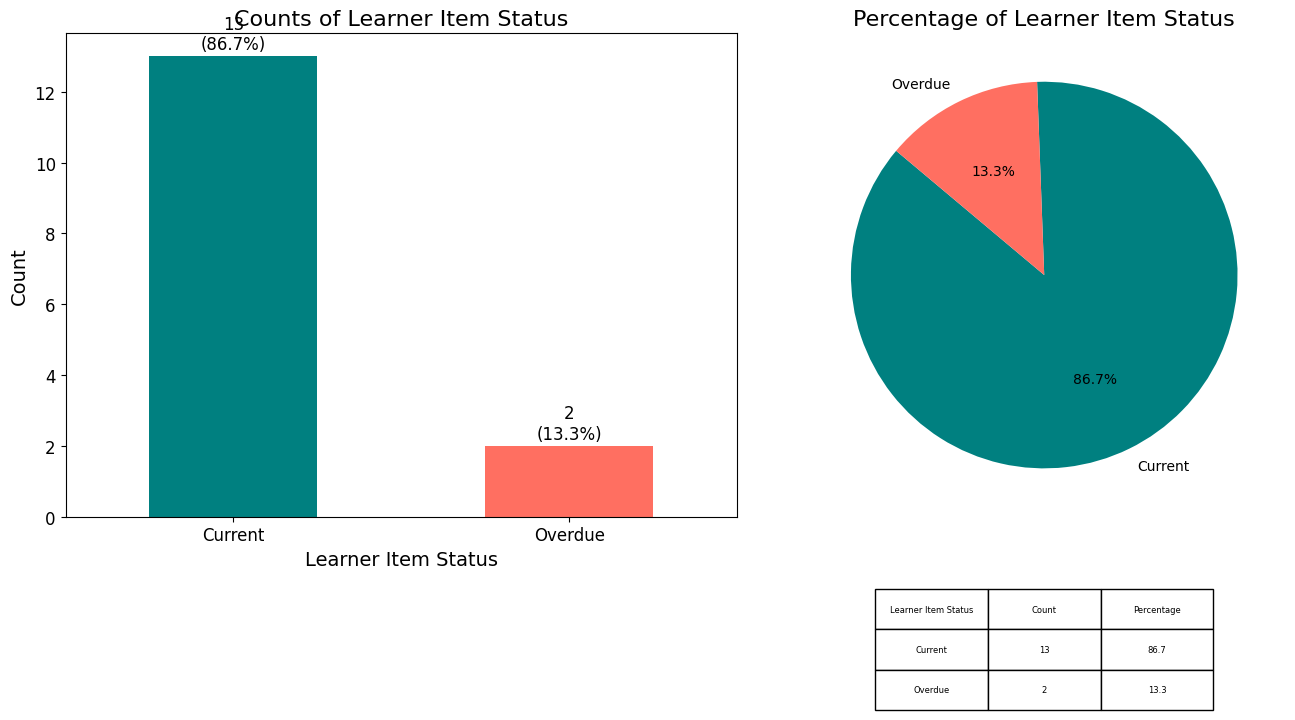

In [17]:
# Spot-check the visual for WDW
generate_plots(dataframes['Disney_Cruise_Line'], 'Disney_Cruise_Line', display=True)


In [15]:
print(dataframes.keys())


dict_keys(['Walt_Disney_World_Resort', 'Disney_Cruise_Line', 'Adventures_by_Disney', 'Disney_Corp_Administration', 'P&R_Administration'])


In [19]:
merged_final.E2.unique()


array(['Ball, Charles A', 'Reid, Linda J', 'Armor, Alison E', nan,
       'Swisher, Jacqueline N', 'Hymel, Pamela', 'Riles, Sarah F',
       'Quinn, Rachel Lydia', 'Penning, Mark R', 'Burns, Stephen H',
       'Simon, Matthew A', 'Smith, Maryann', 'Cressey, Kara K',
       'Stewart, Darla J', 'Moulton, Meredith M', 'Natter, Mark A',
       'Rodriguez, Kartika S', 'Jones, Brian T', 'Valiquette, Melissa M',
       'Duffy, David L', 'Cordero, Gina', 'Cline, Natalie W',
       'Mills, James R', 'Hale, Gregory B', 'Khubchandani, Rajesh',
       'Hale, Andre', 'Vazquez, Ramiro', 'Dillard, Barry',
       'Hughes, Danny E', 'Kelley, Faron D', 'Fabregat, Maria D',
       'Compagnoni, Barry A', 'Gorner, Timo', 'Torres, Sheri A',
       'Sakaske, Shannon', 'Fitzgibbon, Marylouise',
       'Fitton Weinbloom, Jenny D'], dtype=object)

In [20]:
value_counts = merged_final['E2'].value_counts(sort=False)
print(value_counts)

Ball, Charles A               530
Reid, Linda J                4040
Armor, Alison E              1776
Swisher, Jacqueline N         373
Hymel, Pamela                  87
Riles, Sarah F                569
Quinn, Rachel Lydia             3
Penning, Mark R               304
Burns, Stephen H              198
Simon, Matthew A               79
Smith, Maryann                237
Cressey, Kara K               114
Stewart, Darla J                2
Moulton, Meredith M             2
Natter, Mark A                 34
Rodriguez, Kartika S          274
Jones, Brian T                 80
Valiquette, Melissa M          14
Duffy, David L                 36
Cordero, Gina                   6
Cline, Natalie W                2
Mills, James R                 22
Hale, Gregory B                 4
Khubchandani, Rajesh            8
Hale, Andre                     1
Vazquez, Ramiro                 5
Dillard, Barry                 10
Hughes, Danny E                 2
Kelley, Faron D                 1
Fabregat, Mari